In [51]:
import scipy
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymatch
from pymatch.Matcher import Matcher
import sys, re, platform, glob
from tqdm.autonotebook import tqdm

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Fixed seed for reproducibility
np.random.seed(4072021)

print(f"Python version: {sys.version}")
print(f"OS version: {platform.platform()}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"statsmodels version: {statsmodels.__version__}")

Python version: 3.7.5 (v3.7.5:5c02a39a0b, Oct 14 2019, 18:49:57) 
[Clang 6.0 (clang-600.0.57)]
OS version: Darwin-20.2.0-x86_64-i386-64bit
pandas version: 1.3.0
numpy version: 1.21.0
scipy version: 1.7.0
statsmodels version: 0.12.2


## Analysis

### Loading VAERS data

Note: for legal reasons, we cannot reproduce the raw VAERS data in Github. However, you can download the VAERS data set
from [HHS](https://vaers.hhs.gov).

In [52]:
%%time

path = "../data/" # use your path
vaccine_files = glob.glob(path + "*VAERSVAX.csv")

vax_frames = []

for filename in tqdm(vaccine_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    vax_frames.append(df)

vax = pd.concat(vax_frames, axis=0, ignore_index=True)[["VAERS_ID", "VAX_TYPE", "VAX_DOSE_SERIES", "VAX_NAME"]]

# Discard unknown vaccines
vax = vax[vax.VAX_TYPE != "UNK"]

vax["IS_COVID_VACCINE"] = vax["VAX_TYPE"] == "COVID19"

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 1.71 s, sys: 449 ms, total: 2.16 s
Wall time: 2.81 s


In [53]:
%%time

recipient_files = glob.glob(path + "*VAERSDATA.csv")

recipient_frames = []

for filename in tqdm(recipient_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    recipient_frames.append(df)

recipients = pd.concat(recipient_frames, axis=0, ignore_index=True)

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 9.07 s, sys: 1.99 s, total: 11.1 s
Wall time: 11.5 s


In [54]:
%%time

symptoms_files = glob.glob(path + "*VAERSSYMPTOMS.csv")

symptoms_frames = []

for filename in tqdm(symptoms_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    symptoms_frames.append(df)

symptoms = pd.melt(pd.concat(symptoms_frames, axis=0, ignore_index=True)[["VAERS_ID", "SYMPTOM1", "SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]],
               id_vars="VAERS_ID",
               value_vars=(f"SYMPTOM{i}" for i in range(1, 6))).drop("variable", axis=1)

symptoms.columns = ("VAERS_ID", "SYMPTOM")

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 2 s, sys: 586 ms, total: 2.58 s
Wall time: 2.76 s


In [55]:
anaphylactic_presentations = [
    "Anaphylaxis",
    "Anaphylaxis systemic",
    "Anaphylaxis acute",
    "Anaphylactic shock",
    "Anaphylactoid shock",
    "Anaphylactoid reaction",
    "Anaphylactic and anaphylactoid responses"
]

In [56]:
%%time

symptoms["IS_ANAPHYLACTIC"] = symptoms.SYMPTOM.isin(anaphylactic_presentations)
symptoms = symptoms.dropna().groupby("VAERS_ID").agg({"IS_ANAPHYLACTIC": np.max})



CPU times: user 911 ms, sys: 181 ms, total: 1.09 s
Wall time: 1.14 s


In [57]:
data = recipients[["VAERS_ID", "AGE_YRS", "SEX", "ALLERGIES", "HISTORY"]].merge(symptoms, left_on="VAERS_ID", right_index=True, how="inner").merge(vax, how="inner")
data.index = data.VAERS_ID

In [58]:
%%time

df = data[["VAERS_ID", "AGE_YRS", "SEX", "IS_ANAPHYLACTIC", "IS_COVID_VACCINE"]].dropna()

pd.crosstab(df.IS_COVID_VACCINE, df.IS_ANAPHYLACTIC).sort_index(ascending=False).sort_index(axis=1, ascending=False)


CPU times: user 369 ms, sys: 155 ms, total: 524 ms
Wall time: 564 ms


IS_ANAPHYLACTIC,True,False
IS_COVID_VACCINE,,
True,152,390819
False,398,863800


In [59]:
cases = data[data.IS_ANAPHYLACTIC == True][["VAERS_ID", "AGE_YRS", "SEX", "IS_ANAPHYLACTIC", "IS_COVID_VACCINE"]]
controls = data[data.IS_ANAPHYLACTIC == False][["VAERS_ID", "AGE_YRS", "SEX", "IS_ANAPHYLACTIC", "IS_COVID_VACCINE"]]

In [60]:
m = Matcher(cases, controls, yvar="IS_ANAPHYLACTIC", exclude=["VAERS_ID", "IS_COVID_VACCINE"])

Formula:
IS_ANAPHYLACTIC ~ AGE_YRS+SEX
n majority: 1254619
n minority: 550


In [61]:
%%time

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 51.64%
CPU times: user 10.7 s, sys: 1.05 s, total: 11.8 s
Wall time: 12.4 s


In [62]:
%%time

m.predict_scores()

CPU times: user 11.1 s, sys: 3.76 s, total: 14.8 s
Wall time: 5.27 s


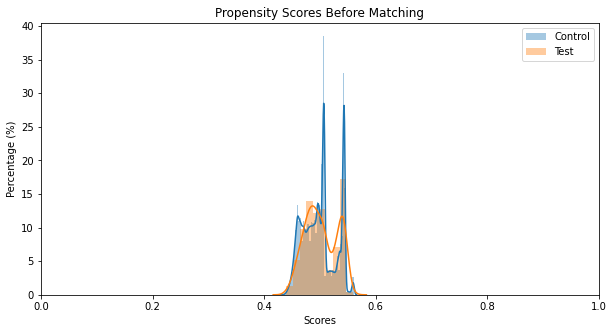

In [63]:
m.plot_scores()
plt.savefig("../writeup/propensity_scores.pdf")

In [64]:
%%time

m.match(method="random", nmatches=3)

CPU times: user 5.88 s, sys: 548 ms, total: 6.43 s
Wall time: 6.51 s


In [65]:
%%time

m.record_frequency()

CPU times: user 5.62 ms, sys: 2.81 ms, total: 8.43 ms
Wall time: 7.01 ms


,freq,n_records
0,1,2038
1,2,1


In [66]:
%%time

m.assign_weight_vector()

CPU times: user 7.74 ms, sys: 2.15 ms, total: 9.89 ms
Wall time: 8.74 ms


In [67]:
df = m.matched_data[m.matched_data.VAERS_ID.isin(df.VAERS_ID)].merge(vax[["VAERS_ID", "VAX_TYPE"]])

### Anaphylaxis OR for all COVID-19 vaccines

In [68]:
pd.crosstab(df.VAX_TYPE == "COVID19", df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)

IS_ANAPHYLACTIC,True,False
VAX_TYPE,,
True,154,556
False,812,2175


In [69]:
contingency_table = sm.stats.Table2x2(pd.crosstab(df.VAX_TYPE == "COVID19", df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False))

print(f"OR for anaphylaxis: {contingency_table.oddsratio:.3f} @ p = {contingency_table.oddsratio_pvalue():.3f}")
print(f"CI: {contingency_table.oddsratio_confint()[0]:.3f} –– {contingency_table.oddsratio_confint()[1]:.3f}")

OR for anaphylaxis: 0.742 @ p = 0.003
CI: 0.610 –– 0.902


### Anaphylaxis OR by vaccine type

In [70]:
odds_ratios_by_vax_type = pd.DataFrame(index = df.VAX_TYPE.unique(),
                                       columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

for vax_type in tqdm(df.VAX_TYPE.unique()):
    ct = sm.stats.Table2x2(pd.crosstab(df.VAX_TYPE == vax_type, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False))
    if ct.table_orig[True][True] >= 15:
        odds_ratios_by_vax_type.loc[vax_type, "ROR"] = ct.oddsratio
        odds_ratios_by_vax_type.loc[vax_type, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_vax_type.loc[vax_type, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_vax_type.loc[vax_type, "95CI_upper"] = ct.oddsratio_confint()[1]

  0%|          | 0/62 [00:00<?, ?it/s]

In [71]:
ors = odds_ratios_by_vax_type.dropna().drop("OPV")
ors.to_csv("../supplementary/odds_ratios_by_vaccine_type_for_anaphylaxis.csv")

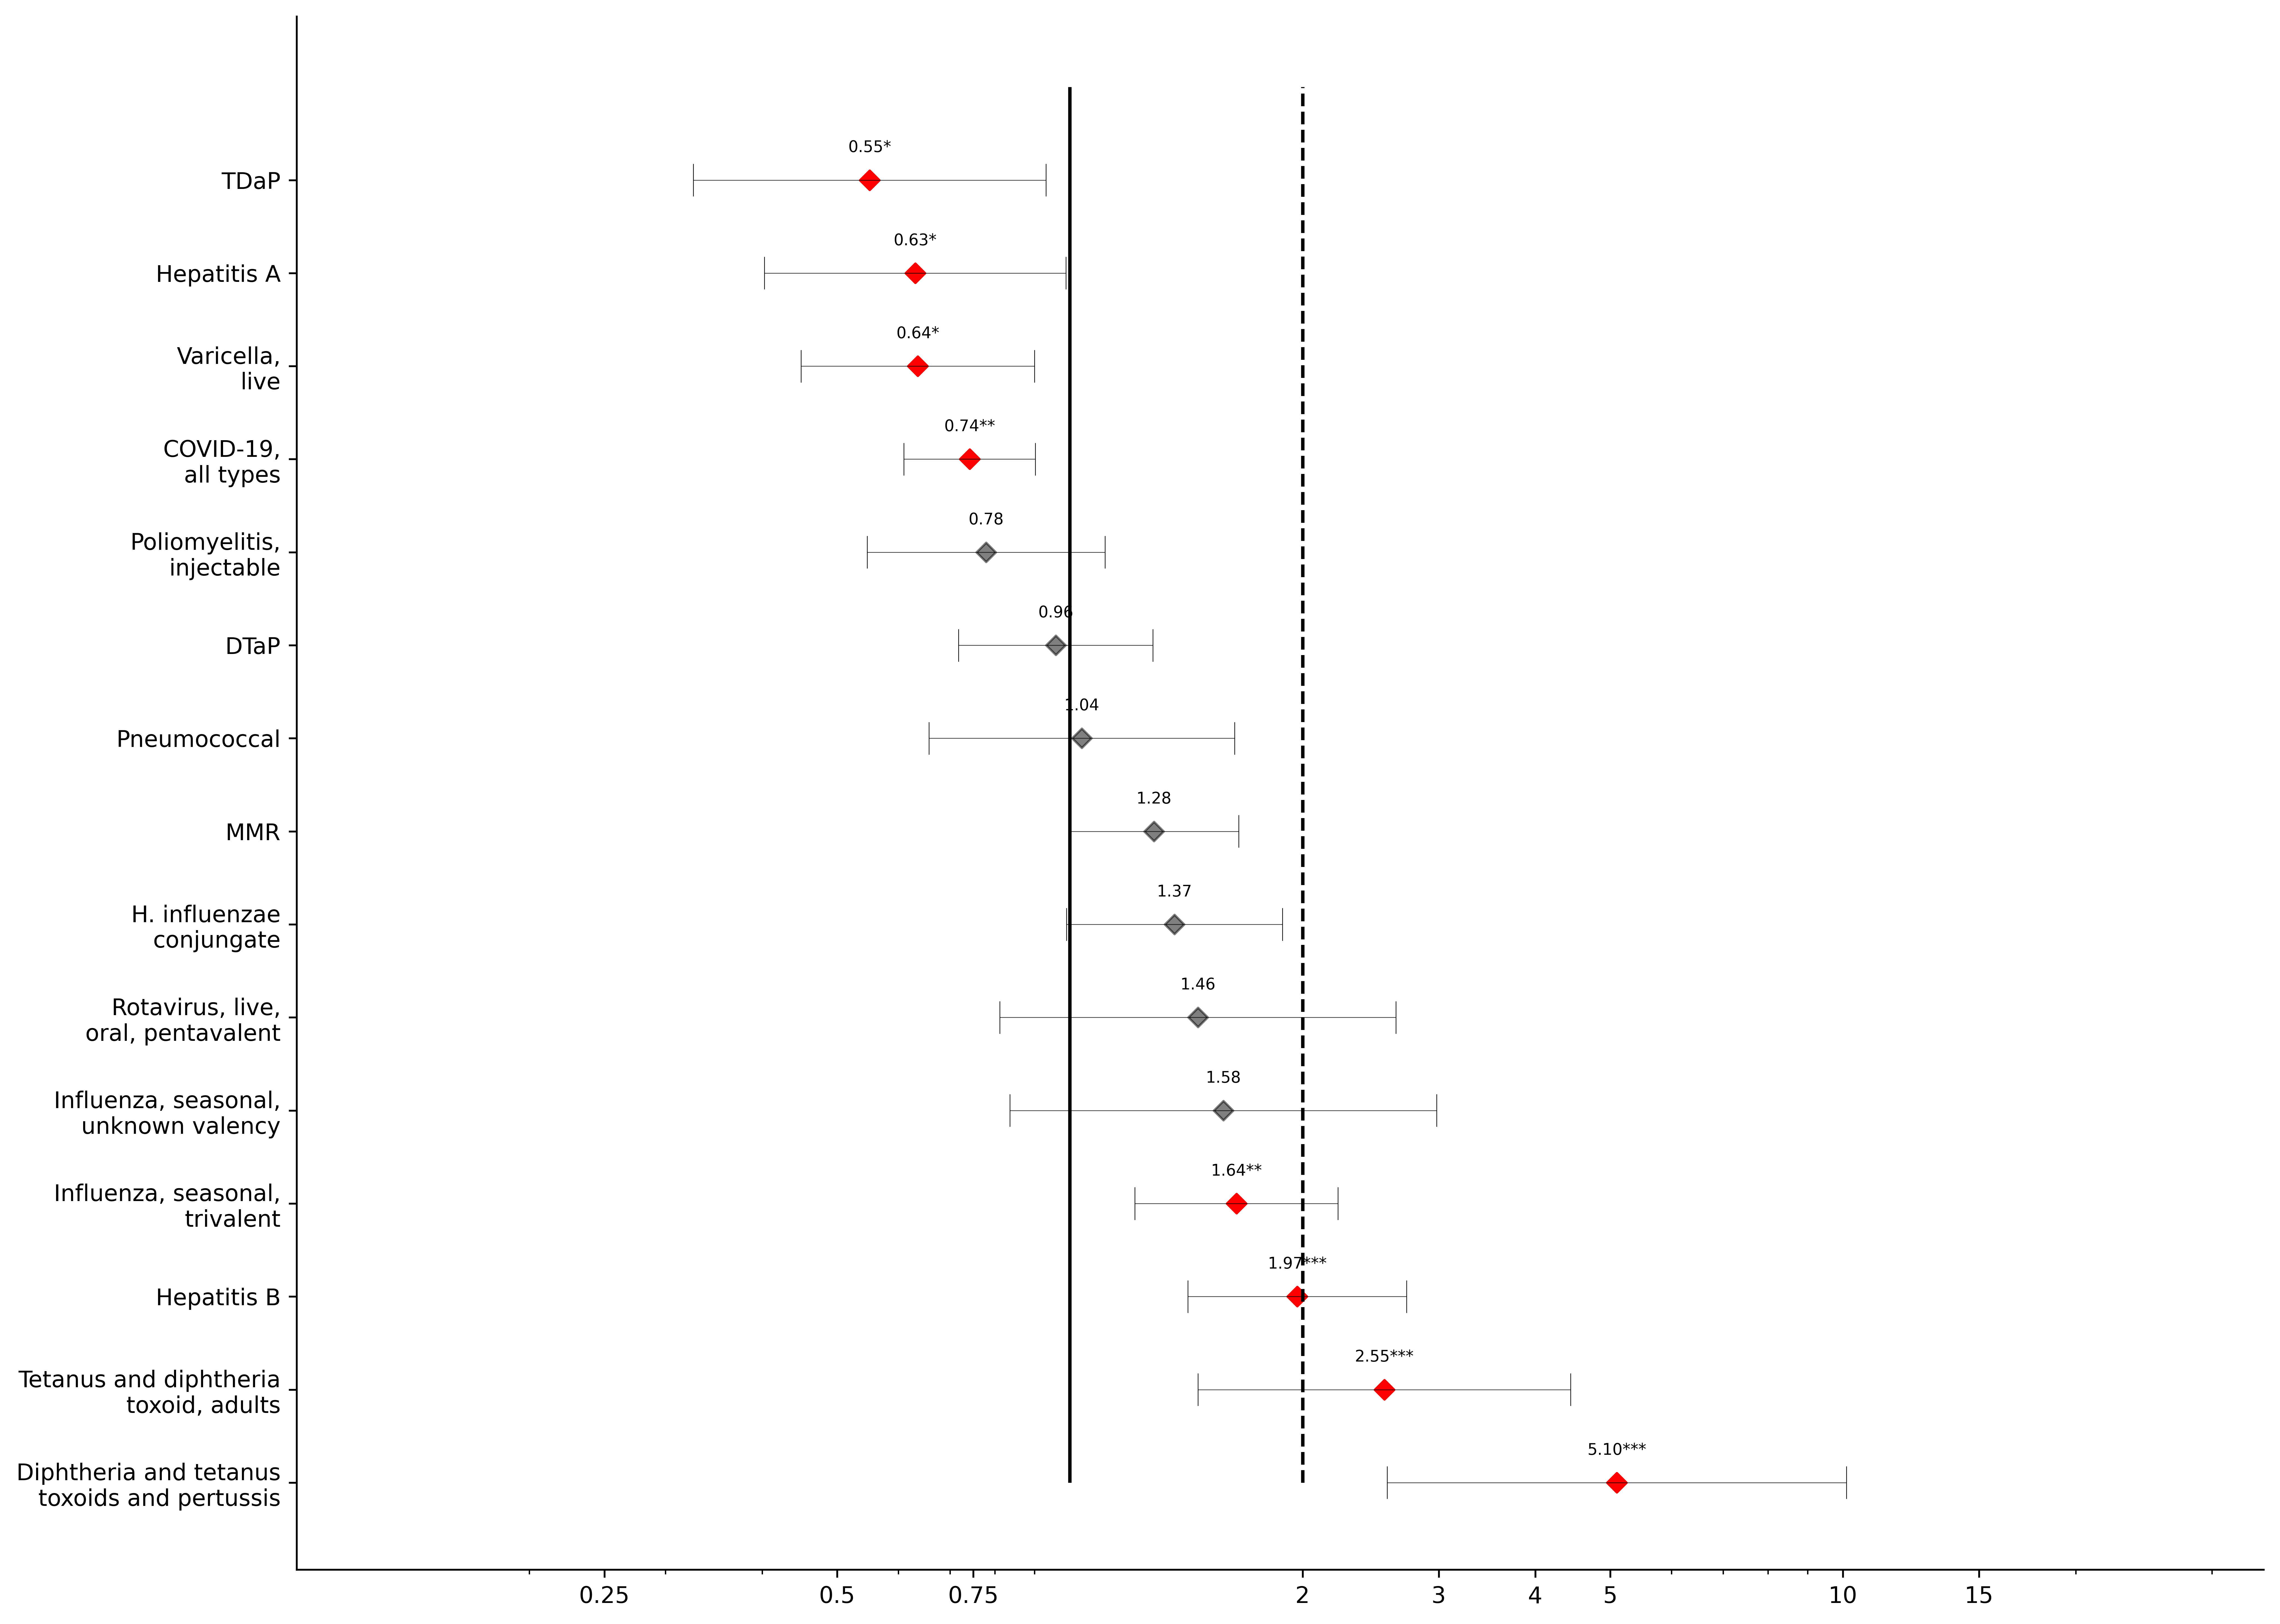

In [72]:
WHISKER:float = 0.175

ors = ors.sort_values("ROR", ascending=False)

fig, ax = plt.subplots(figsize=(14, 10), dpi=600)

ax.scatter(ors.ROR, ors.index, marker="D", color="k", alpha=0.5)
ax.scatter(ors[ors.p_value < 0.05].ROR, ors[ors.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=0, ymax=len(ors.index), colors="k")
ax.vlines(x=2, ymin=0, ymax=len(ors.index), colors="k", linestyles="--")

for idx, val in enumerate(ors.index):
    ax.hlines(y=idx, xmin=ors.loc[val, "95CI_lower"], xmax=ors.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if ors.loc[val, "p_value"] < 0.001 else ("**" if ors.loc[val, "p_value"] < 0.005 else ("*" if ors.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = ors.loc[val, "ROR"], s = f"{ors.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")
    ax.vlines(x=ors.loc[val, "95CI_lower"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)
    ax.vlines(x=ors.loc[val, "95CI_upper"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)

ax.set_xscale("log")
ax.set_xlim(1e-1, 3.5e1)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xticks([0.25, 0.5, 0.75, 2, 3, 4, 5, 10, 15])
ax.set_xticklabels([0.25, 0.5, 0.75, 2, 3, 4, 5, 10, 15])

ax.set_yticks(["TDAP", "HEPA", "VARCEL", "IPV", "COVID19", "DTAP", "PPV", "MMR", "HIBV", "RV5", "FLUX", "FLU3", "TD", "HEP", "DTP"])
ax.set_yticklabels(["TDaP", "Hepatitis A", "Varicella,\nlive", "Poliomyelitis,\ninjectable", "COVID-19,\nall types", "DTaP", "Pneumococcal", "MMR", "H. influenzae\nconjungate", "Rotavirus, live,\noral, pentavalent", "Influenza, seasonal,\nunknown valency", "Influenza, seasonal,\ntrivalent", "Tetanus and diphtheria\ntoxoid, adults", "Hepatitis B", "Diphtheria and tetanus\ntoxoids and pertussis"])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_of_anaphylaxis.pdf")

plt.show()


### Odds ratios by gender


In [73]:
odds_ratios_by_gender = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

for gender in tqdm(data[data.VAERS_ID.isin(m.matched_data.VAERS_ID.unique())].SEX.unique()):
    df = data[(data.VAERS_ID.isin(m.matched_data.VAERS_ID.unique())) & (data.SEX == gender)]
    ct = sm.stats.Table2x2(pd.crosstab(df.IS_COVID_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False))
    if ct.table_orig[True][True] >= 15:
        odds_ratios_by_gender.loc[gender, "ROR"] = ct.oddsratio
        odds_ratios_by_gender.loc[gender, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_gender.loc[gender, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_gender.loc[gender, "95CI_upper"] = ct.oddsratio_confint()[1]


  0%|          | 0/3 [00:00<?, ?it/s]

### Odds ratios by age band

In [74]:
odds_ratios_by_age_band = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

In [75]:
data["age_band"] = pd.cut(data.AGE_YRS,
                          bins=(0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 120),
                          labels=("<18", "19-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "86-95", ">95"),
                          right=True)

In [76]:
for age_band in tqdm(data[data.VAERS_ID.isin(m.matched_data.VAERS_ID.unique())].age_band.unique()):
    try:
        df = data[(data["age_band"] == age_band) & (data.VAERS_ID.isin(m.matched_data.VAERS_ID.unique()))]
        xt = pd.crosstab(df.IS_COVID_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_age_band.loc[age_band, "ROR"] = ct.oddsratio
        odds_ratios_by_age_band.loc[age_band, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_age_band.loc[age_band, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_age_band.loc[age_band, "95CI_upper"] = ct.oddsratio_confint()[1]
    except ValueError:
        continue

  0%|          | 0/10 [00:00<?, ?it/s]

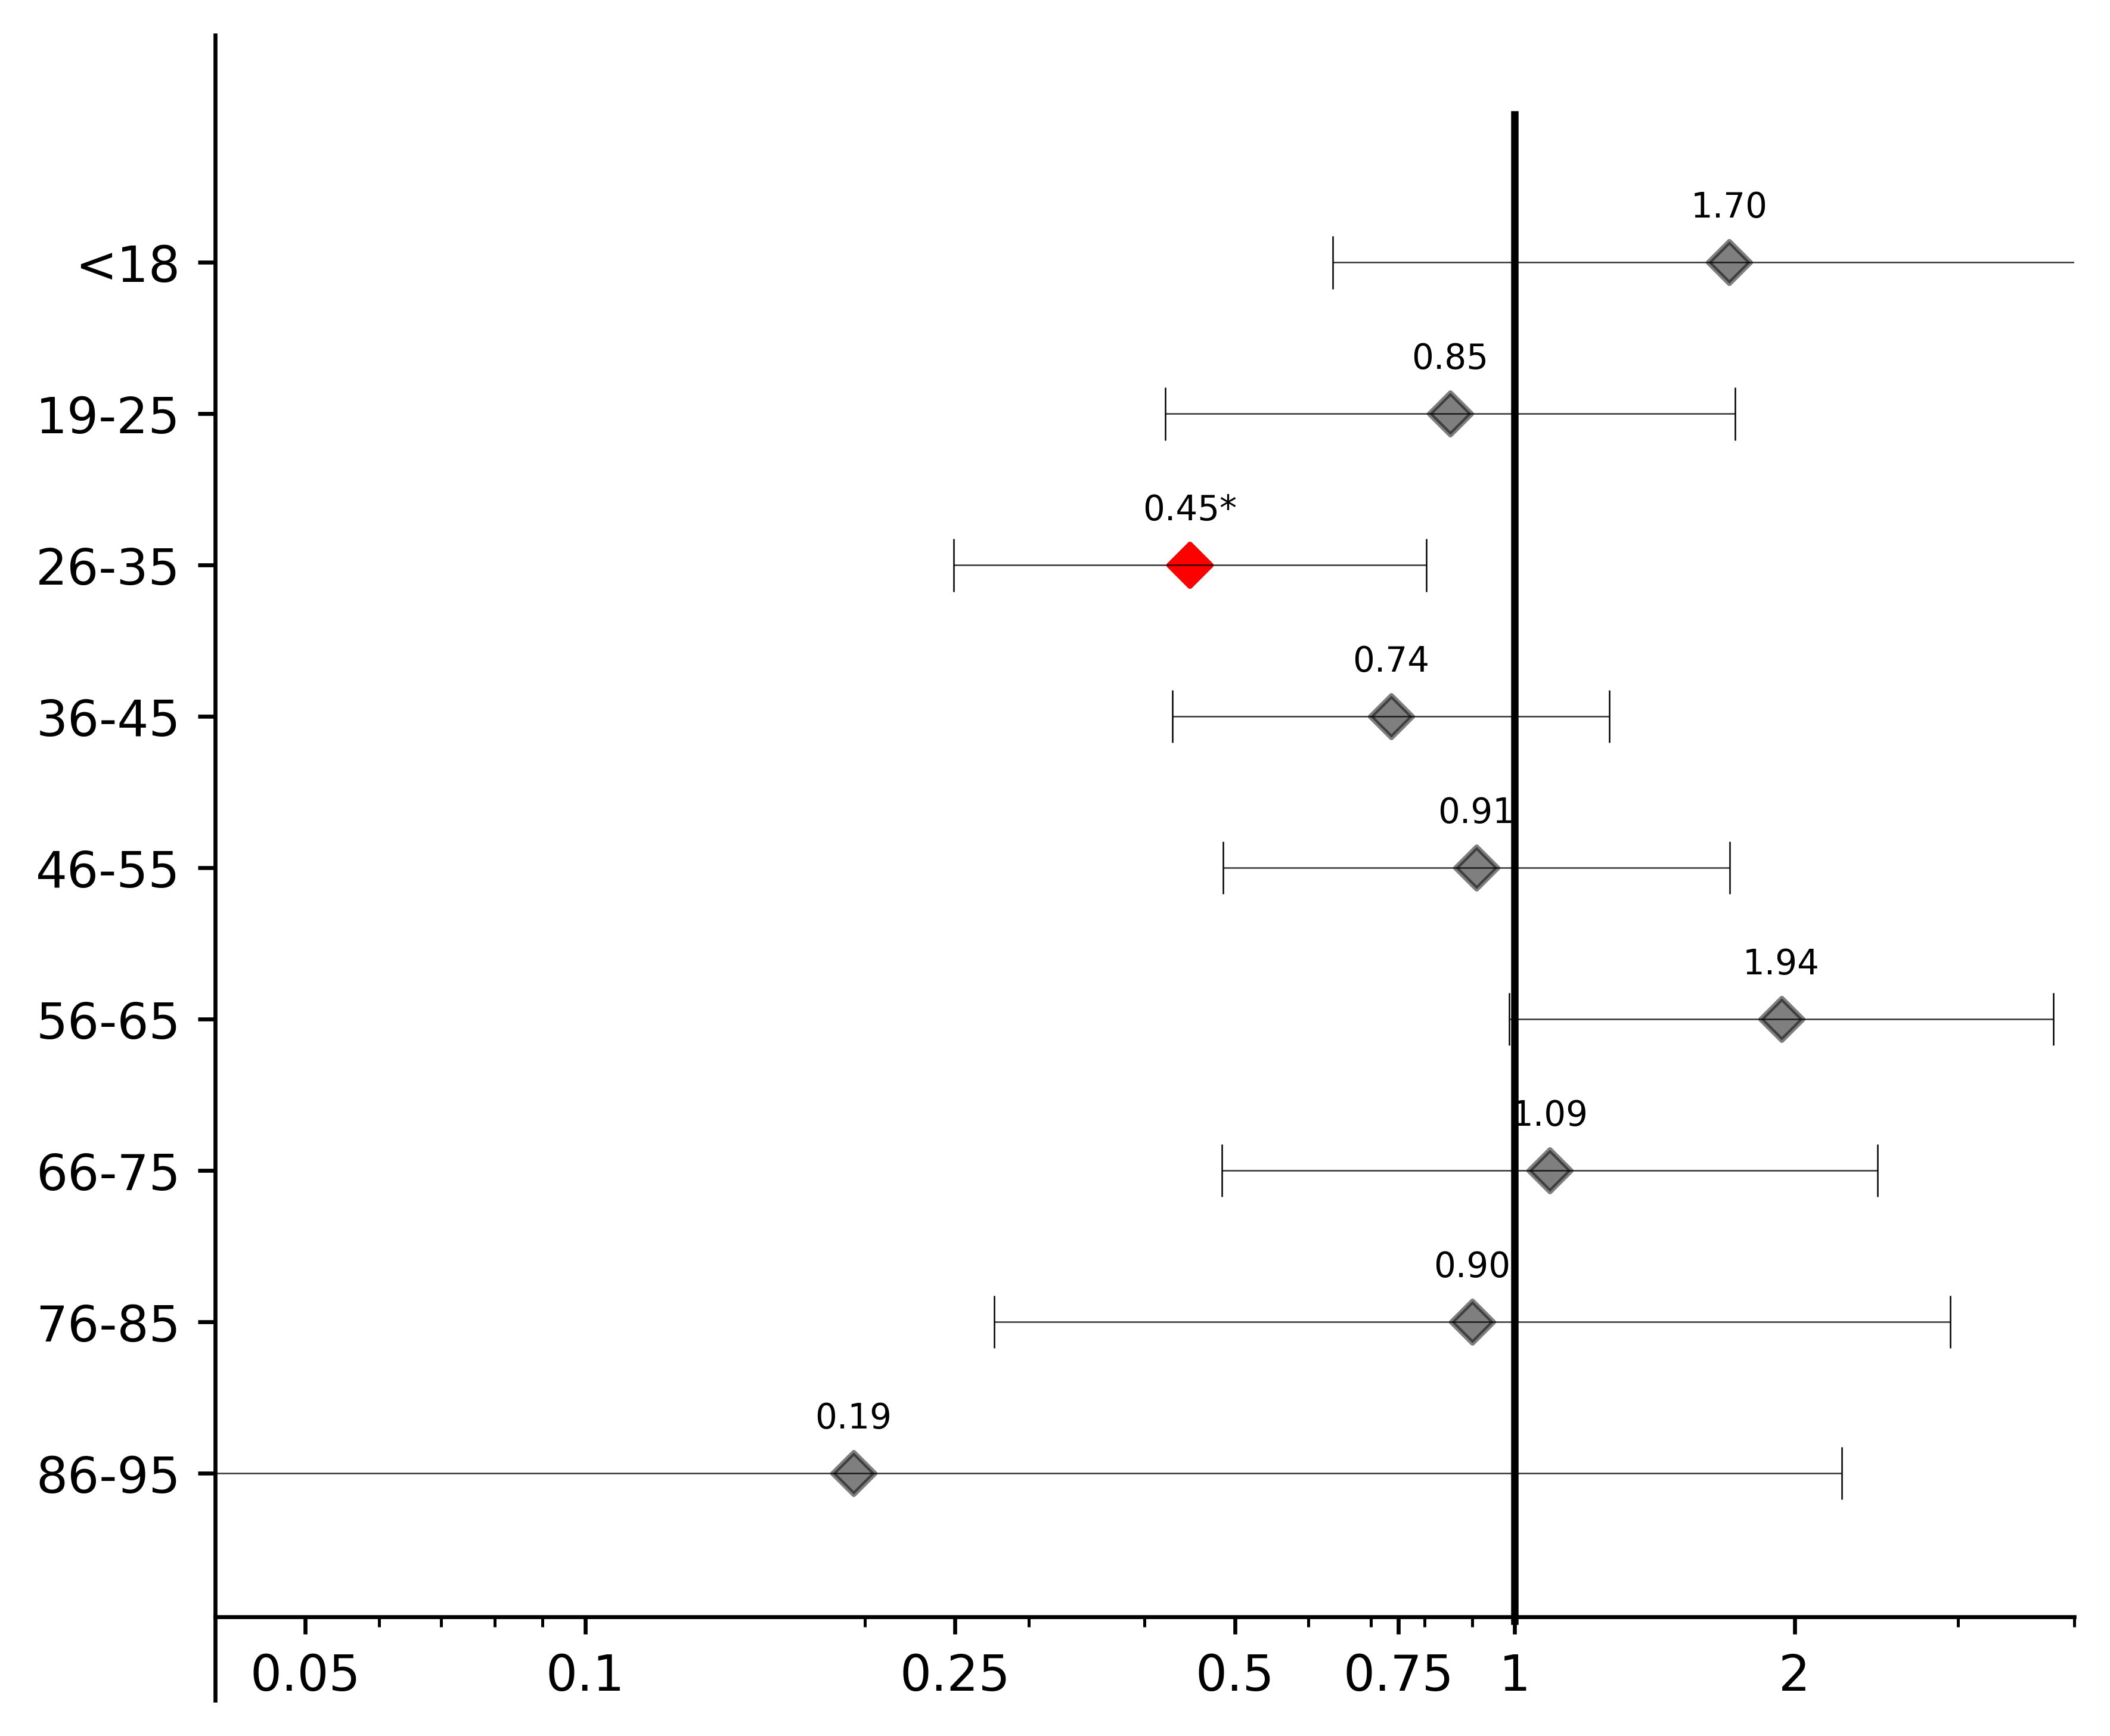

In [77]:
WHISKER:float = 0.175

fig, ax = plt.subplots(figsize=(6, 5), dpi=600)

odds_ratios_by_age_band.index = pd.CategoricalIndex(odds_ratios_by_age_band.index,
                                                    categories = ["<18", "19-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "86-95"],
                                                    ordered=True)

odds_ratios_by_age_band = odds_ratios_by_age_band.sort_index(ascending=False)

ax.scatter(odds_ratios_by_age_band.ROR, odds_ratios_by_age_band.index, marker="D", color="k", alpha=0.5)
ax.scatter(odds_ratios_by_age_band[odds_ratios_by_age_band.p_value < 0.05].ROR, odds_ratios_by_age_band[odds_ratios_by_age_band.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=-1, ymax=len(odds_ratios_by_age_band.index), colors="k")

for idx, val in enumerate(odds_ratios_by_age_band.index):
    ax.hlines(y=idx, xmin=odds_ratios_by_age_band.loc[val, "95CI_lower"], xmax=odds_ratios_by_age_band.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.001 else ("**" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.005 else ("*" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = odds_ratios_by_age_band.loc[val, "ROR"], s = f"{odds_ratios_by_age_band.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")
    ax.vlines(x=odds_ratios_by_age_band.loc[val, "95CI_lower"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)
    ax.vlines(x=odds_ratios_by_age_band.loc[val, "95CI_upper"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)

ax.set_xscale("log")
ax.set_xlim(4e-2, 4e0)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0.05))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xticks([0.05, 0.1, 0.25, 0.5, 0.75, 1, 2])
ax.set_xticklabels([0.05, 0.10, 0.25, 0.5, 0.75, 1, 2])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_of_anaphylaxis_by_age.pdf")

plt.show()


### Odds ratios by known allergies

In [78]:
extractors:dict = {
    "Opioids": r".*(cod(e)?(i|o)n(e)?|orphine|fenta|CDN|Demerol|contin|(o|i)cet|dilaud|methad|talwin|pentazocin(e)?).*",
    "Latex": r".*latex.*",
    "Macrolide and amino-\nglycoside antibiotics": r".*(mycin|Zithro|Z-pack|macroli|neosporin).*",
    "Tetracycline\nantibiotics": r".*(cycline).*",
    "Sulfas": r".*(sulf(a|ur|onam)|bactrim|sulfamet|SMX).*",
    "Beta-lactam\nantbiotics": r".*(pen(n)?(i|e)|keflex|ce(f|ph)a|cill(l)?in|augmentin|PCN|amox|roce(f|ph)).*",
    "Fluoroquinolone\nantibiotics": r".*(floxacin|cipro|quinolo).*",
    "HCTZ": ".*(h(ctz|ydrochlorothiazide)).*",
    "Glycols": r".*(PEG|(polyeth|prop)ylene glycol).*",
    "Local anaesthetics": r".*(caine).*",
    "Known vaccine\nhypersensitivities": r".*(va(x|cc)|bexsero|mmr|tetanus|tdap|dtap|prevnar|pneumovax|shingles|hepatitis).*",
    "Fish and/or\nseafood": r".*(fish|sea(\s)?food|mussels|crab|scallops).*",
    "Insect stings": r".*(bee|wasp|sting).*",
    "Eggs": r".*(egg).*",
    "NSAIDs": r".*(ibuprofen|motrin|advil|acetamino|nsaid|coxib|celebrex|APAP|as(a|pirin)|voltaren|naprox|to(d|r)olac|vioxx|mobic).*",
    "Peanuts and\ntree nuts": r".*(nut).*"
}

In [79]:
odds_ratios_by_preexisting_allergy = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

In [80]:
for key in tqdm(extractors):
    try:
        df = data[data.VAERS_ID.isin(m.matched_data.VAERS_ID.unique())].dropna()[data[data.VAERS_ID.isin(m.matched_data.VAERS_ID.unique())].dropna().ALLERGIES.str.match(re.compile(extractors[key], re.IGNORECASE))]
        xt = pd.crosstab(df.IS_COVID_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_preexisting_allergy.loc[key, "ROR"] = ct.oddsratio
        odds_ratios_by_preexisting_allergy.loc[key, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_preexisting_allergy.loc[key, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_preexisting_allergy.loc[key, "95CI_upper"] = ct.oddsratio_confint()[1]
    except ValueError:
        continue


  0%|          | 0/16 [00:00<?, ?it/s]

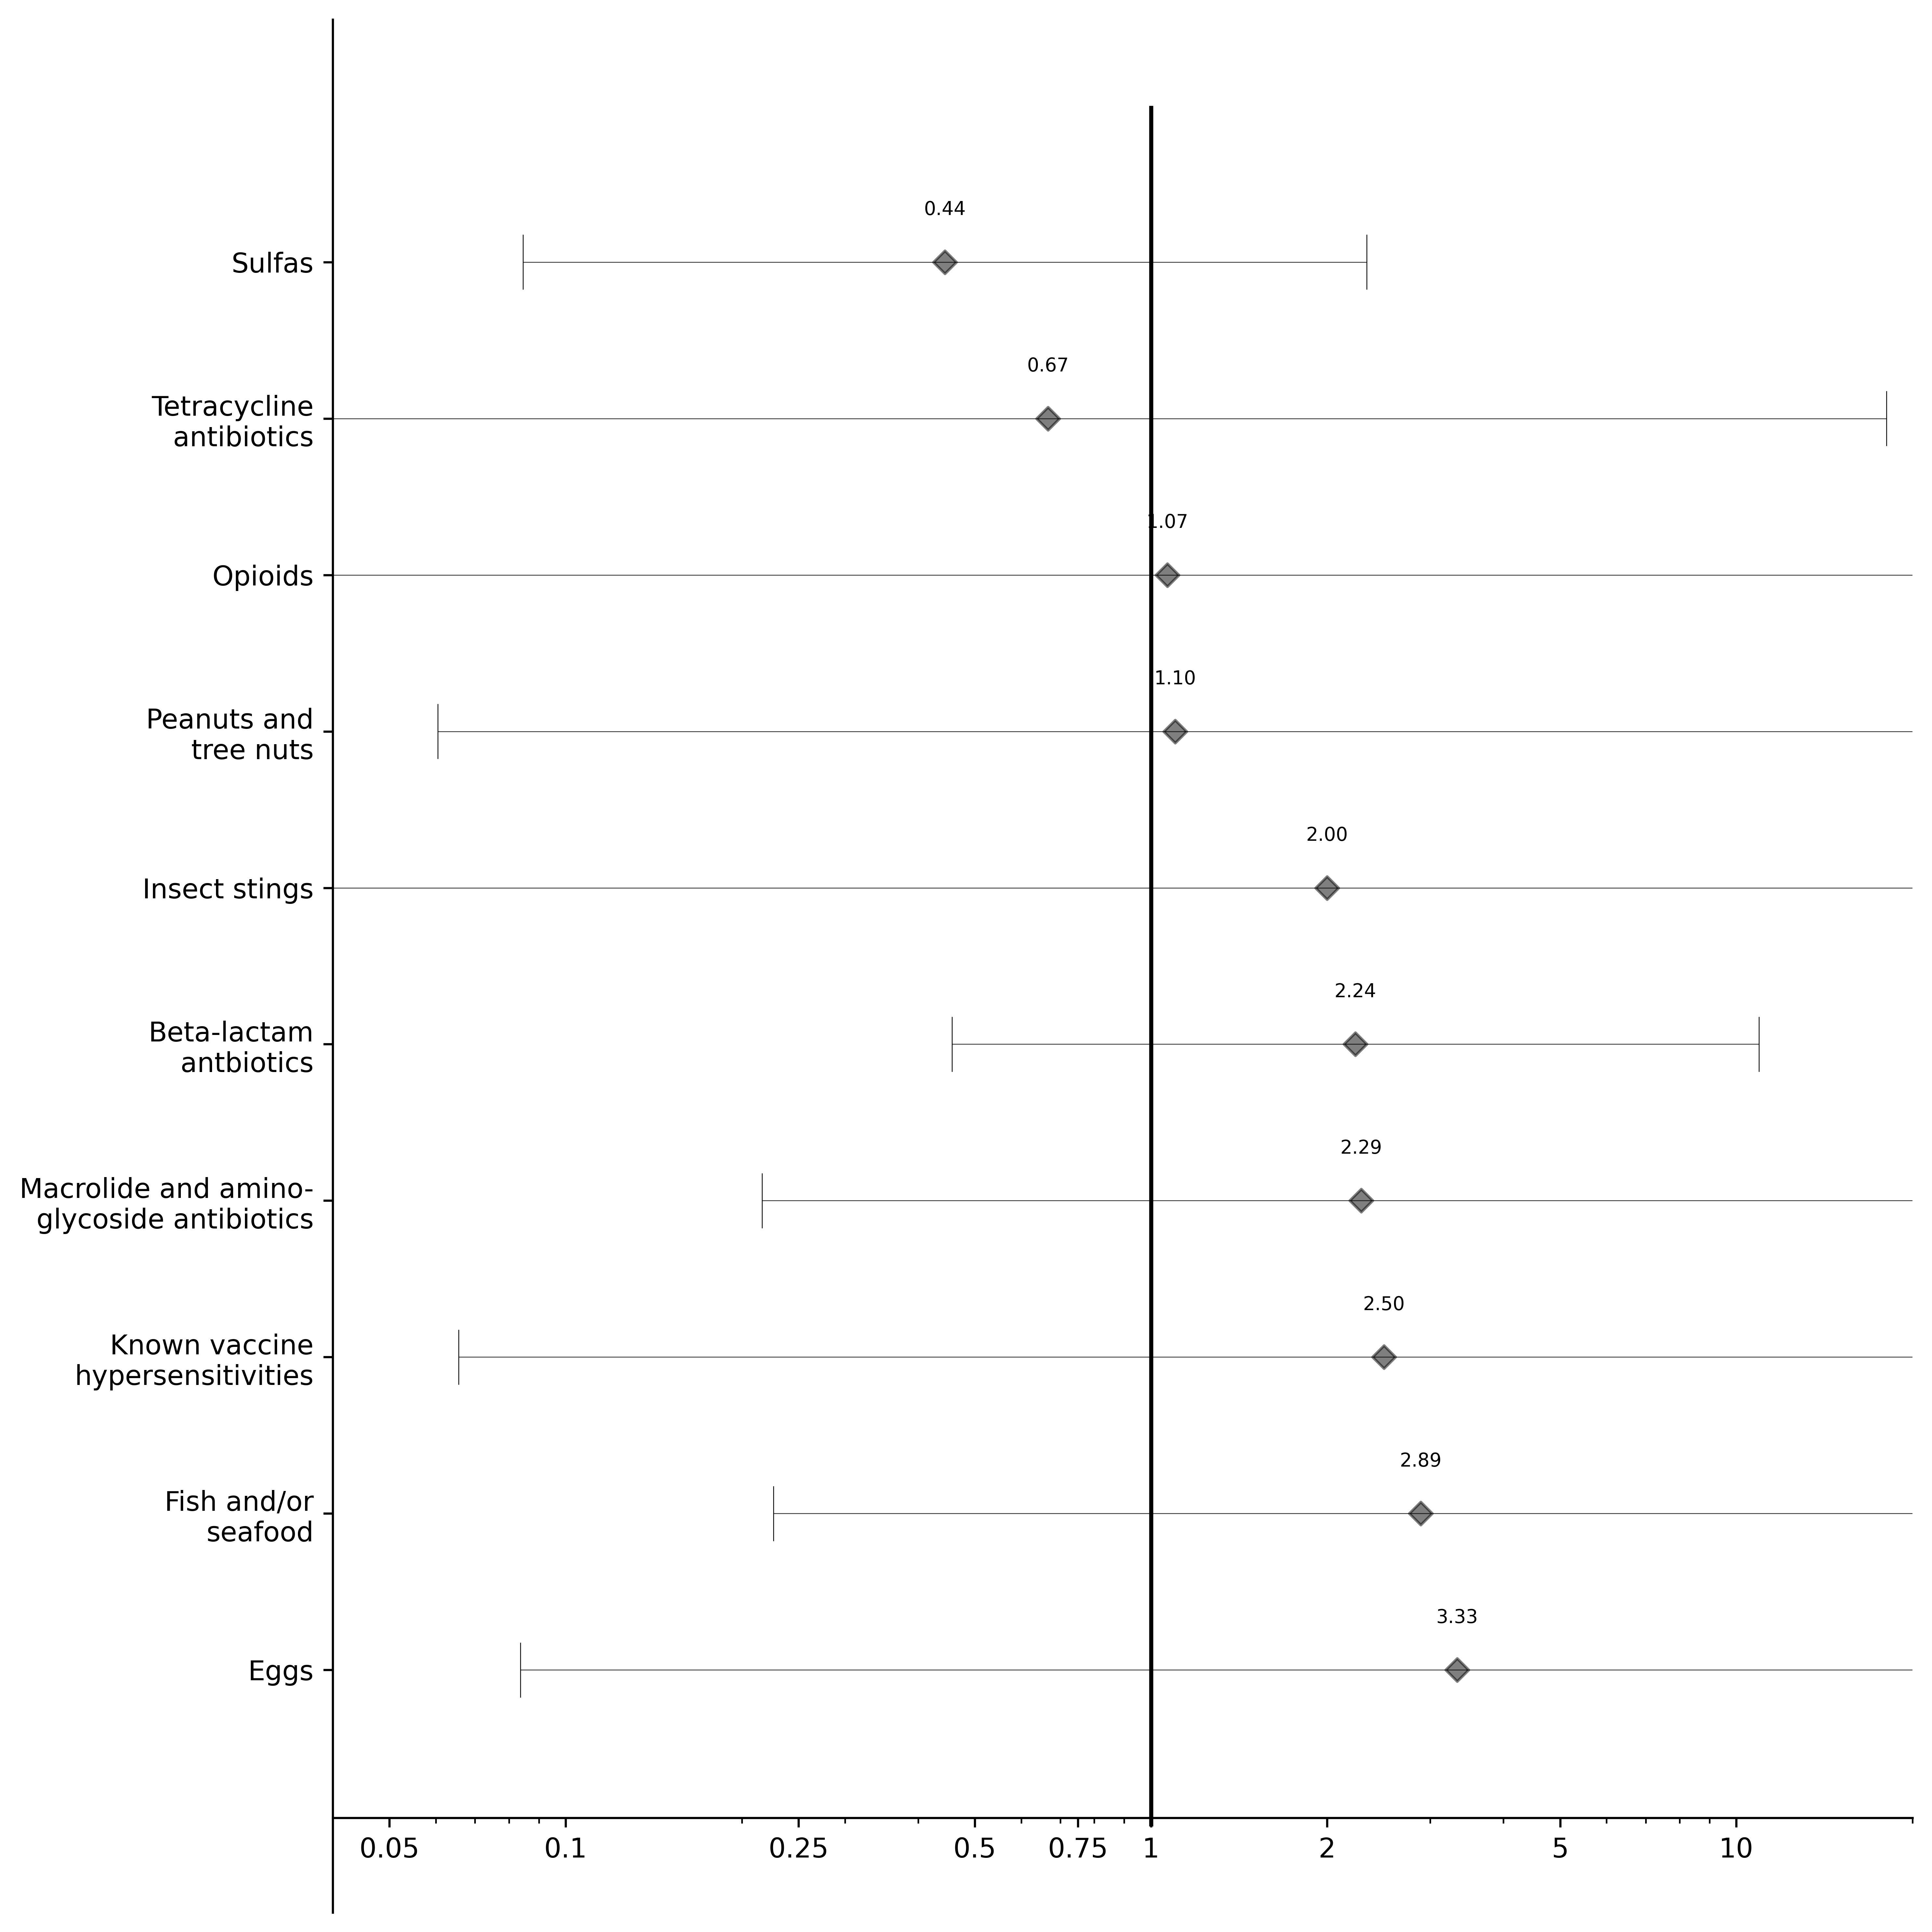

In [81]:
WHISKER:float = 0.175

fig, ax = plt.subplots(figsize=(10, 10), dpi=600)

odds_ratios_by_preexisting_allergy = odds_ratios_by_preexisting_allergy.sort_values("ROR", ascending=False)

ax.scatter(odds_ratios_by_preexisting_allergy.ROR, odds_ratios_by_preexisting_allergy.index, marker="D", color="k", alpha=0.5)
ax.scatter(odds_ratios_by_preexisting_allergy[odds_ratios_by_preexisting_allergy.p_value < 0.05].ROR, odds_ratios_by_preexisting_allergy[odds_ratios_by_preexisting_allergy.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=-1, ymax=len(odds_ratios_by_preexisting_allergy.index), colors="k")

for idx, val in enumerate(odds_ratios_by_preexisting_allergy.index):
    ax.hlines(y=idx, xmin=odds_ratios_by_preexisting_allergy.loc[val, "95CI_lower"], xmax=odds_ratios_by_preexisting_allergy.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.001 else ("**" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.005 else ("*" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = odds_ratios_by_preexisting_allergy.loc[val, "ROR"], s = f"{odds_ratios_by_preexisting_allergy.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")
    ax.vlines(x=odds_ratios_by_preexisting_allergy.loc[val, "95CI_lower"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)
    ax.vlines(x=odds_ratios_by_preexisting_allergy.loc[val, "95CI_upper"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)

ax.set_xscale("log")
ax.set_xlim(4e-2, 2e1)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0.05))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xticks([0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10])
ax.set_xticklabels([0.05, 0.10, 0.25, 0.5, 0.75, 1, 2, 5, 10])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_of_anaphylaxis_by_known_allergies.pdf")

plt.show()

### Odds ratios by history

In [82]:
extractors:dict = {
    "Anaphylaxis": r".*(anaphyla(c|x)).*",
    "Asthma": r".*(asthma).*",
    "Atopic dermatitis\nand eczema": r".*((atopic dermatitis)|eczema|rash|hives).*",
    "Allergies, NOS": r".*(allerg(y|i(es|c))|(previous reaction)).*",
    "Seasonal allergies\nand rhinitis": r".*(hay fever|seasonal|rhin(osinus)?itis).*",
    "Mast cell disorders": r".*(mast(\scell|ocytos)|MCAS).*",
    "Coeliac disease": r".*(gluten|c(o)?eliac).*",
    "Lactose intolerance": r".*(lactose intolerance).*",
    "Idiopathic anaphylaxis,\nHAE and related conditions": r".*((HAE|hereditary angi(o)?edema|C(-)?1)|(idiopathic anaphylaxis)).*",
    "Diabetes": r".*(diabetes|(N)?IDDM|T(1|2)D).*",
    "Obesity": r".*(obes|overw|BMI|body mass).*",
    "Hypertension": r".*(HTN|hypertension|(high|elevated) (BP|blood pressure)).*",
    "Hypothyroidism\nand related": r".*(hypothyroid|Hashimoto|thyroiditis).*",
    "Past\nCOVID-19": r".*co(vid|ronavirus).*"
}

In [83]:
odds_ratios_by_history = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

In [84]:
for key in tqdm(extractors):
    try:
        df = data[data.VAERS_ID.isin(m.matched_data.VAERS_ID.unique())].dropna()[data[data.VAERS_ID.isin(m.matched_data.VAERS_ID.unique())].dropna().HISTORY.str.match(re.compile(extractors[key], re.IGNORECASE))]
        xt = pd.crosstab(df.IS_COVID_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_history.loc[key, "ROR"] = ct.oddsratio
        odds_ratios_by_history.loc[key, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_history.loc[key, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_history.loc[key, "95CI_upper"] = ct.oddsratio_confint()[1]
    except ValueError:
        continue


  0%|          | 0/14 [00:00<?, ?it/s]

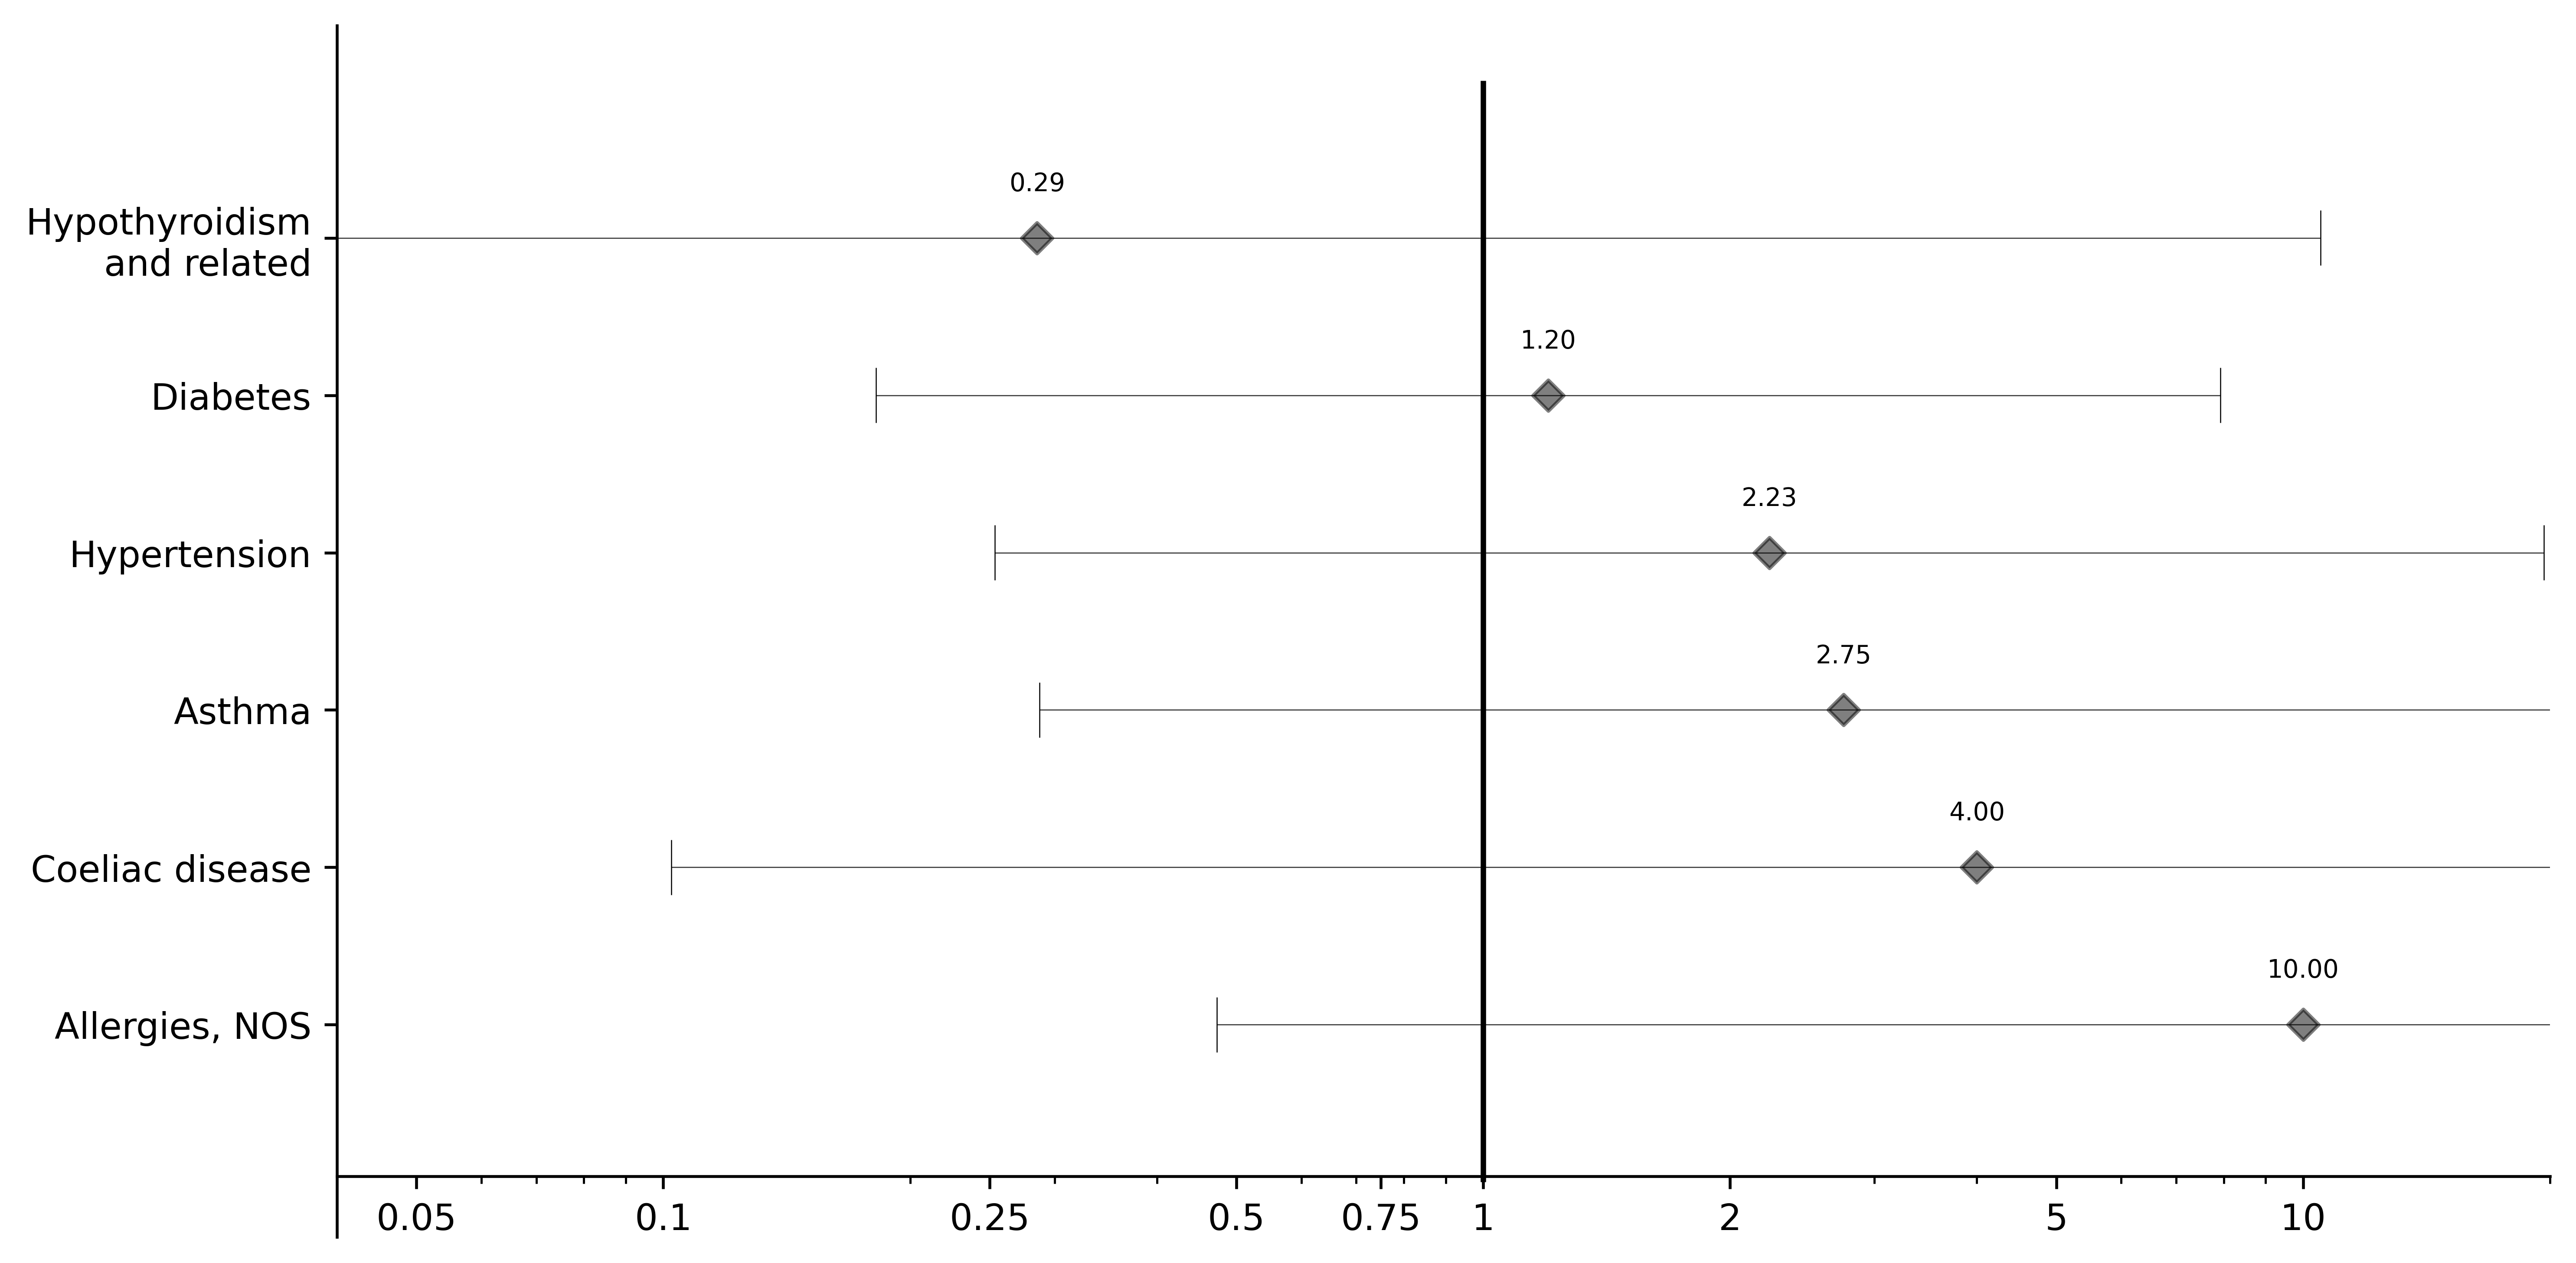

In [85]:
WHISKER:float = 0.175

fig, ax = plt.subplots(figsize=(10, 5), dpi=600)

odds_ratios_by_history = odds_ratios_by_history.sort_values("ROR", ascending=False)

ax.scatter(odds_ratios_by_history.ROR, odds_ratios_by_history.index, marker="D", color="k", alpha=0.5)
ax.scatter(odds_ratios_by_history[odds_ratios_by_history.p_value < 0.05].ROR, odds_ratios_by_history[odds_ratios_by_history.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=-1, ymax=len(odds_ratios_by_history.index), colors="k")

for idx, val in enumerate(odds_ratios_by_history.index):
    ax.hlines(y=idx, xmin=odds_ratios_by_history.loc[val, "95CI_lower"], xmax=odds_ratios_by_history.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if odds_ratios_by_history.loc[val, "p_value"] < 0.001 else ("**" if odds_ratios_by_history.loc[val, "p_value"] < 0.005 else ("*" if odds_ratios_by_history.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = odds_ratios_by_history.loc[val, "ROR"], s = f"{odds_ratios_by_history.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")
    ax.vlines(x=odds_ratios_by_history.loc[val, "95CI_lower"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)
    ax.vlines(x=odds_ratios_by_history.loc[val, "95CI_upper"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)

ax.set_xscale("log")
ax.set_xlim(4e-2, 2e1)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0.05))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xticks([0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10])
ax.set_xticklabels([0.05, 0.10, 0.25, 0.5, 0.75, 1, 2, 5, 10])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_of_anaphylaxis_by_history.pdf")

plt.show()